<a href="https://colab.research.google.com/github/ahmadarbain/EDA-Titanic/blob/main/ForecastingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collecting

In [1]:
# Install and use library

!pip install TM1py
import sys
import traceback
import pandas as pd
import numpy as np

import xgboost
import pickle
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import process_time
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from TM1py import TM1Service

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for TM1py: filename=TM1py-1.10.1-py3-none-any.whl size=132157 sha256=465aabde885b8ebe1ba45cd04d71f16c67b91111be7239c4bfedd5b30e393693
  Stored in directory: /root/.cache/pip/wheels/fc/b1/e2/1d39cda374f6ef6c7f02759d52ae61bd1ec809e2c633523553
  Created wheel for mdxpy: filename=mdxpy-1.1-py3-none-any.whl size=11550 sha256=a5306c3870657de1354c96c0a3b61618abd75fc4e421388af416043716d7bb0a
  Stored in directory: /root/.cache/pip/wheels/b2/84/b7/1c661a4c63309f3e7ed8bc450f70954664ed8620da4d779a5d
Successfully built TM1py mdxpy


In [2]:
# Generate data from TM1
try:
  ADDRESS = '18.142.3.196'
  PORT = 5060
  USER = 'admin'
  PWD = 'cognos123'
  SSL = False

  tm1 = TM1Service(address=ADDRESS, port=PORT, user=USER, password=PWD, ssl=SSL)
  print("=== Connection Established ===")
    
except Exception as e:
  print("Unexpected error Connection:", sys.exc_info()[0])
  print(e)
  traceback.print_exc()
  context = {
      "message": "Connection Error. Unexpected error:"+sys.exc_info()[0].__name__
  }

=== Connection Established ===


In [3]:
# Generate data from cube TM1
try:
  cube = 'Source Cube'
  view = 'Datasource'
  table = tm1.cubes.cells.execute_view_dataframe_pivot(cube_name=cube, view_name=view, private=False)
  print("Generated Data is Success")
except Exception as e:
  #print("Unexpected error Extraction:", sys.exc_info()[0], e.message)
  print(e)
  traceback.print_exc()
  context = {
      "message": "Get Data Error. Unexpected error:"+sys.exc_info()[0].__name__
  }

Generated Data is Success


# Data Preprocessing

In [4]:
flattable = pd.DataFrame(table.to_records())
flattable.head()

,Version,Year,Months,Markets,Products,"('Values', 'Actuals')","('Values', 'Actuals -1')","('Values', 'Actuals -2')","('Values', 'Altimeter')","('Values', 'Avg Wind Speed')",...,"('Values', 'Hour of Sun')","('Values', 'Inflation')","('Values', 'Precip_flag')","('Values', 'Pressure')","('Values', 'Rain in Inches')","('Values', 'Snow in Inches')","('Values', 'Temp')","('Values', 'Thunder')","('Values', 'Unemployment')","('Values', 'Visibility')"
0,Basis,2016,1,Argentina,200S,62.0,0.0,0.0,30.99,5.3,...,26.0,1.6,0.0,30.0,0.14,1.8,26.01,0.0,9.1,14.0
1,Basis,2016,1,Argentina,300S,45.0,0.0,0.0,30.99,5.3,...,26.0,1.6,0.0,30.0,0.14,1.8,26.01,0.0,9.1,14.0
2,Basis,2016,1,Argentina,600S,74.0,0.0,0.0,30.99,5.3,...,26.0,1.6,0.0,30.0,0.14,1.8,26.01,0.0,9.1,14.0
3,Basis,2016,1,Argentina,626S,107.0,0.0,0.0,30.99,5.3,...,26.0,1.6,0.0,30.0,0.14,1.8,26.01,0.0,9.1,14.0
4,Basis,2016,1,Argentina,676RS,83.0,0.0,0.0,30.99,5.3,...,26.0,1.6,0.0,30.0,0.14,1.8,26.01,0.0,9.1,14.0


In [5]:
flattable.columns = ['Version', 'Year', 'Months', 'Markets', 'Products', 'Actuals', 'Actuals-1', 'Actuals-2',
                     'Altimeter', 'Avg_Wind_Speed', 'Business_Days', 'Consumer_Spending', 'Hour_of_Sun', 'Inflation',
                     'Precip_Flag','Pressure', 'Rain_in_Inches', 'Snow_in_Inches', 'Temp', 'Thunder', 'Unemployment',
                     'Visibility']

In [6]:
flattable['Year'] = flattable['Year'].astype(int)
flattable['Months'] = flattable['Months'].astype(int)
flattable['Actuals'] = flattable['Actuals'].astype(float)
flattable['Actuals-1'] = flattable['Actuals-1'].astype(float)
flattable['Actuals-2'] = flattable['Actuals-2'].astype(float)
flattable['Altimeter'] = flattable['Altimeter'].astype(float)
flattable['Avg_Wind_Speed'] = flattable['Avg_Wind_Speed'].astype(float)
flattable['Business_Days'] = flattable['Business_Days'].astype(int)
flattable['Consumer_Spending'] = flattable['Consumer_Spending'].astype(float)
flattable['Hour_of_Sun'] = flattable['Hour_of_Sun'].astype(int)
flattable['Inflation'] = flattable['Inflation'].astype(float)
flattable['Precip_Flag'] = flattable['Precip_Flag'].astype(float)
flattable['Pressure'] = flattable['Pressure'].astype(int)
flattable['Rain_in_Inches'] = flattable['Rain_in_Inches'].astype(float)
flattable['Snow_in_Inches'] = flattable['Snow_in_Inches'].astype(float)
flattable['Temp'] = flattable['Temp'].astype(float)
flattable['Thunder'] = flattable['Thunder'].astype(float)
flattable['Unemployment'] = flattable['Unemployment'].astype(float)
flattable['Visibility'] = flattable['Visibility'].astype(int)

# Exploratory Data Analysis

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
flattable['Version'].describe()

count     15312
unique        1
top       Basis
freq      15312
Name: Version, dtype: object

In [9]:
flattable['Months'] = pd.to_numeric(flattable['Months'], errors='coerce')

In [10]:
flattable = flattable.sort_values(by=['Year','Months'])

In [11]:
flattable

,Version,Year,Months,Markets,Products,Actuals,Actuals-1,Actuals-2,Altimeter,Avg_Wind_Speed,...,Hour_of_Sun,Inflation,Precip_Flag,Pressure,Rain_in_Inches,Snow_in_Inches,Temp,Thunder,Unemployment,Visibility
0,Basis,2016,1,Argentina,200S,62.0,0.000000,0.000000,30.99,5.300000,...,26,1.6,0.000000,30,0.140000,1.800000,26.010000,0.0,9.100000,14
1,Basis,2016,1,Argentina,300S,45.0,0.000000,0.000000,30.99,5.300000,...,26,1.6,0.000000,30,0.140000,1.800000,26.010000,0.0,9.100000,14
2,Basis,2016,1,Argentina,600S,74.0,0.000000,0.000000,30.99,5.300000,...,26,1.6,0.000000,30,0.140000,1.800000,26.010000,0.0,9.100000,14
3,Basis,2016,1,Argentina,626S,107.0,0.000000,0.000000,30.99,5.300000,...,26,1.6,0.000000,30,0.140000,1.800000,26.010000,0.0,9.100000,14
4,Basis,2016,1,Argentina,676RS,83.0,0.000000,0.000000,30.99,5.300000,...,26,1.6,0.000000,30,0.140000,1.800000,26.010000,0.0,9.100000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12755,Basis,2019,12,US,RoadStar,0.0,55.800914,58.721628,30.67,13.233333,...,18,2.2,0.333333,91,0.936667,1.833333,17.264512,0.0,7.766667,11
12756,Basis,2019,12,US,ST1200,0.0,46.653223,49.095132,30.67,13.233333,...,18,2.2,0.333333,91,0.936667,1.833333,17.264512,0.0,7.766667,11
12757,Basis,2019,12,US,ST1200R,0.0,79.584910,83.750519,30.67,13.233333,...,18,2.2,0.333333,91,0.936667,1.833333,17.264512,0.0,7.766667,11
12758,Basis,2019,12,US,ST900,0.0,30.187380,31.767438,30.67,13.233333,...,18,2.2,0.333333,91,0.936667,1.833333,17.264512,0.0,7.766667,11


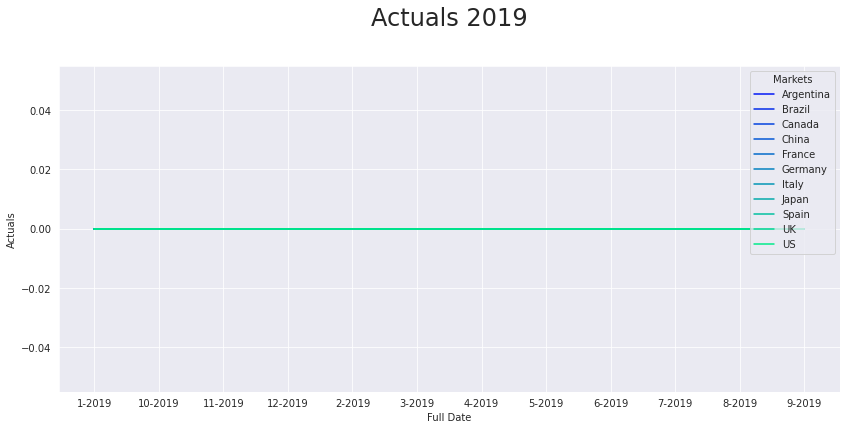

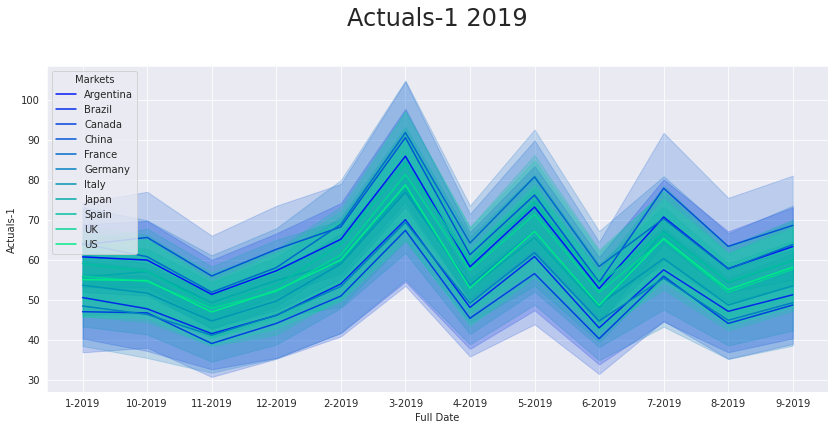

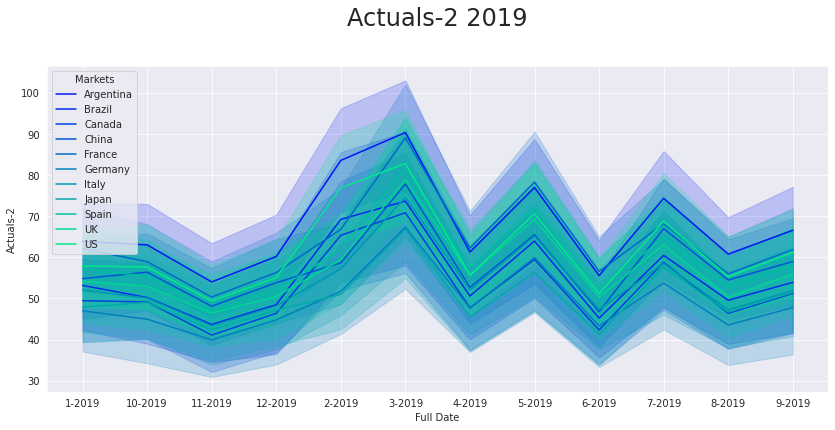

In [14]:
actual = ['Actuals', 'Actuals-1', 'Actuals-2']

df = flattable.loc[flattable['Year'] == i]
df = pd.DataFrame(df, columns= ['Months','Year']) 
df['Full Date'] = df['Months'].map(str) + '-' + df['Year'].map(str)
  
for j in actual:
    plt.figure(figsize=(14,6))
    plt.title(j +" "+ str(i), fontsize=24, pad=40)
    sns.set_style('darkgrid')
    sns.lineplot(
    data = flattable,
    x = df['Full Date'],
    y = j,
    hue = 'Markets',
    palette="winter"
);

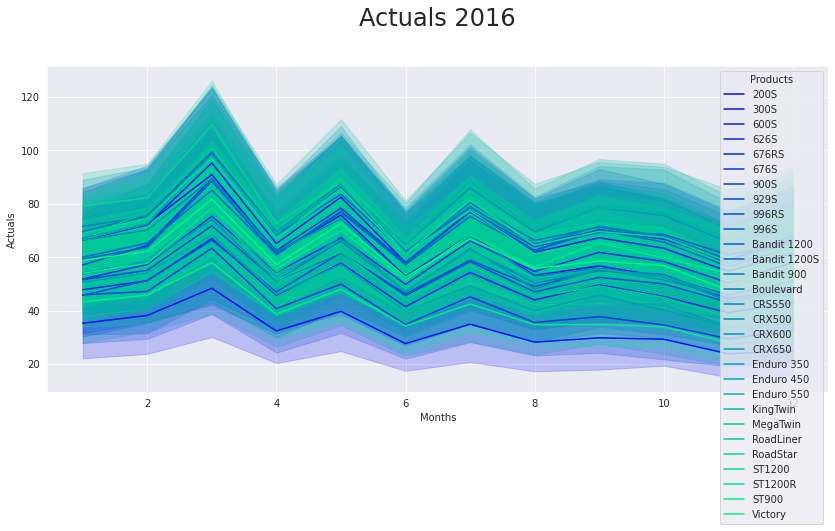

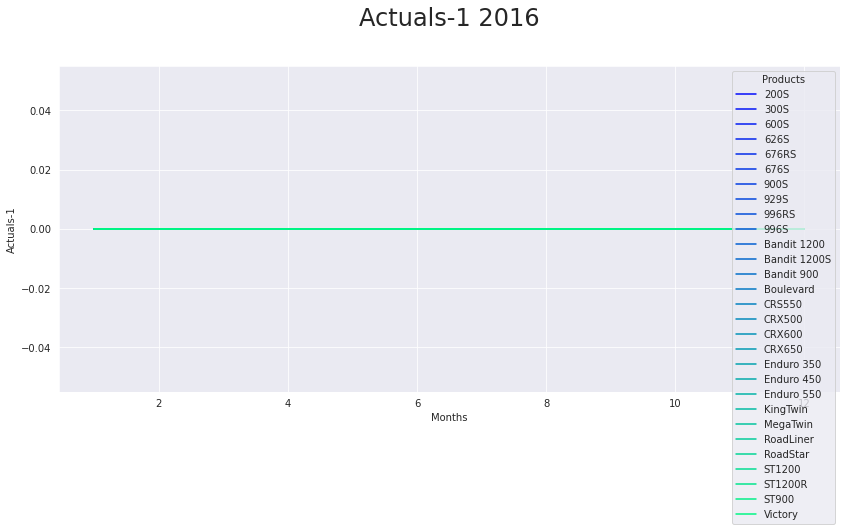

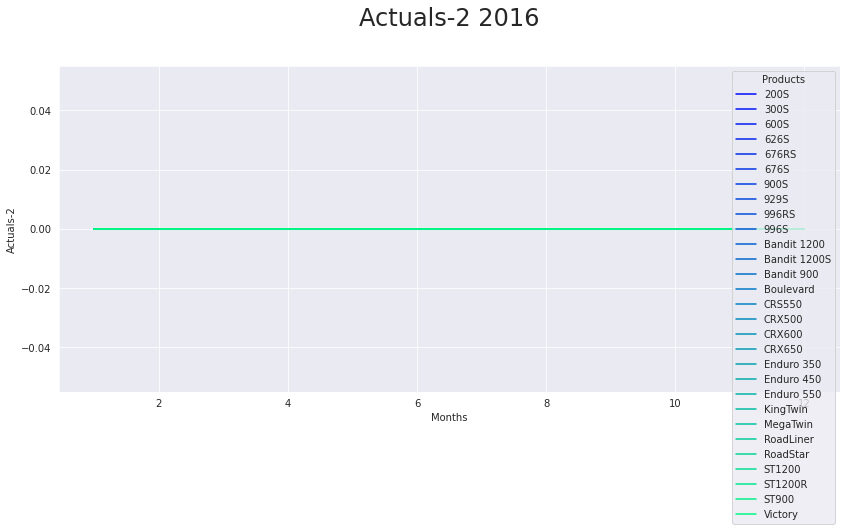

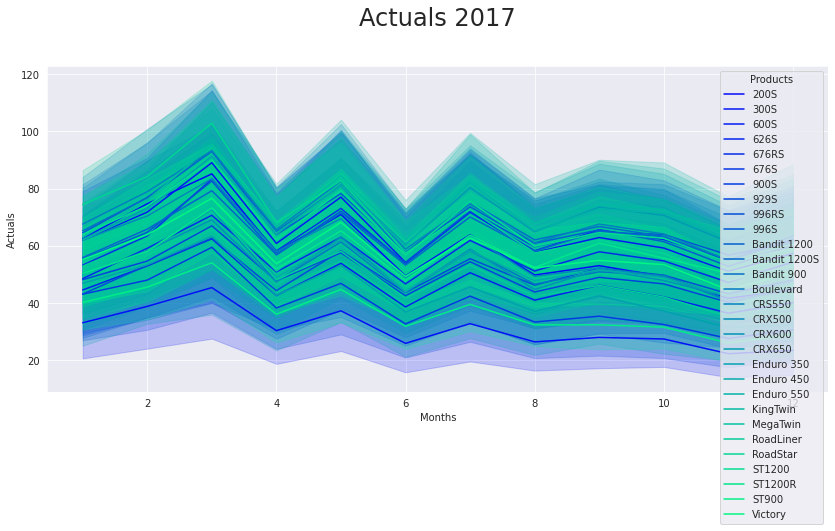

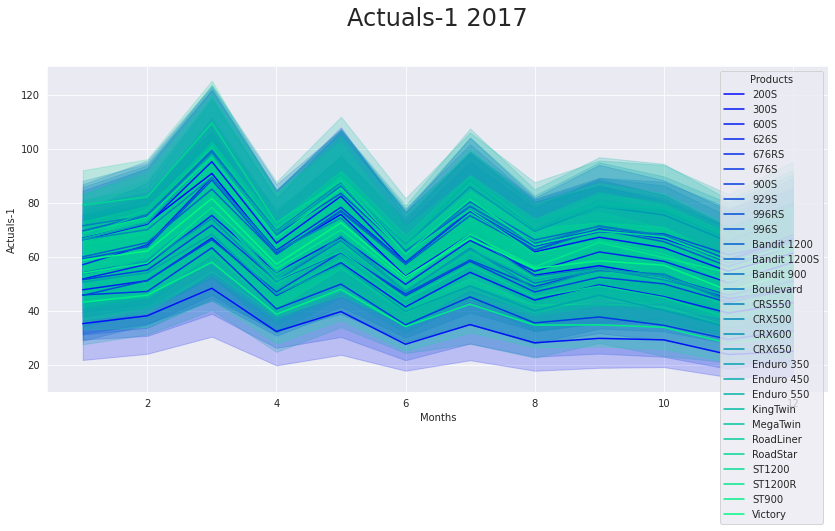

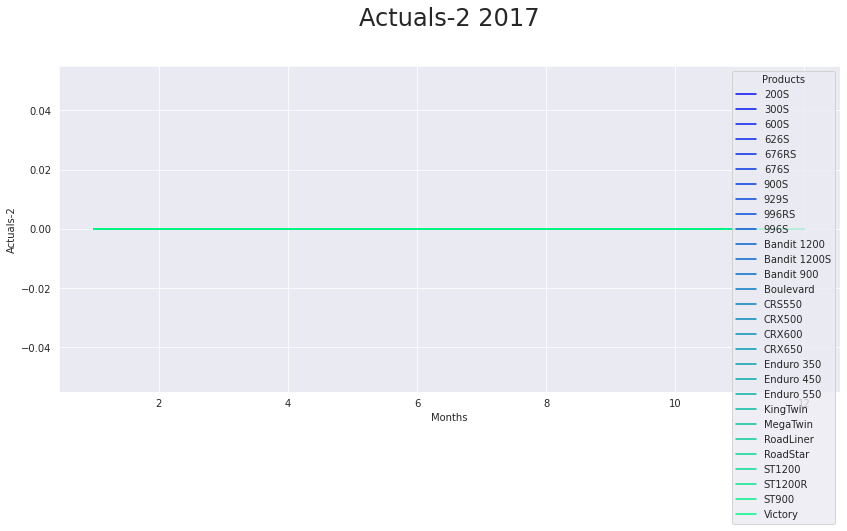

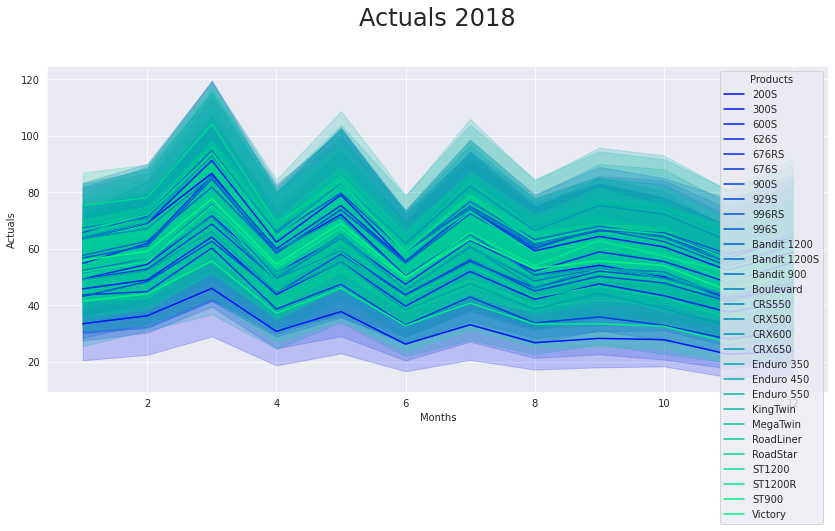

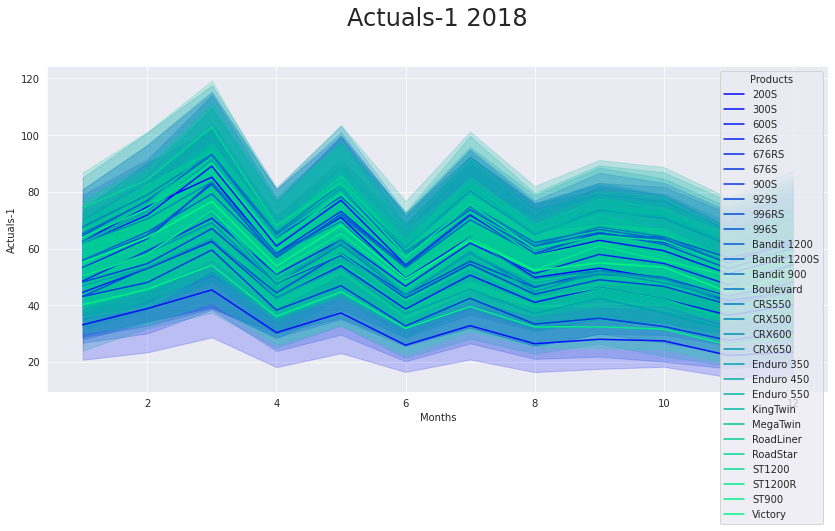

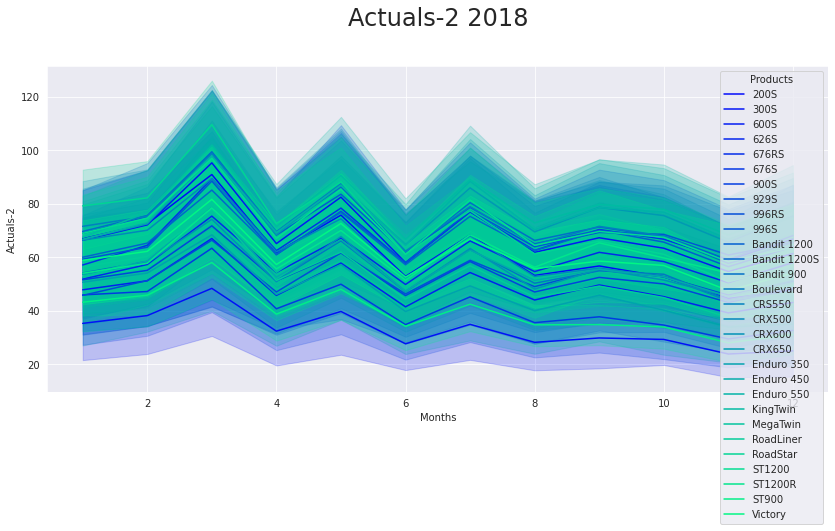

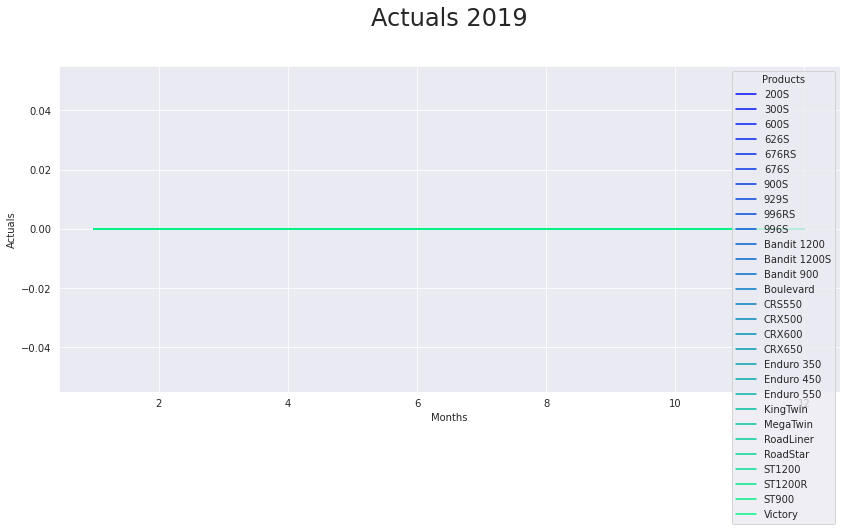

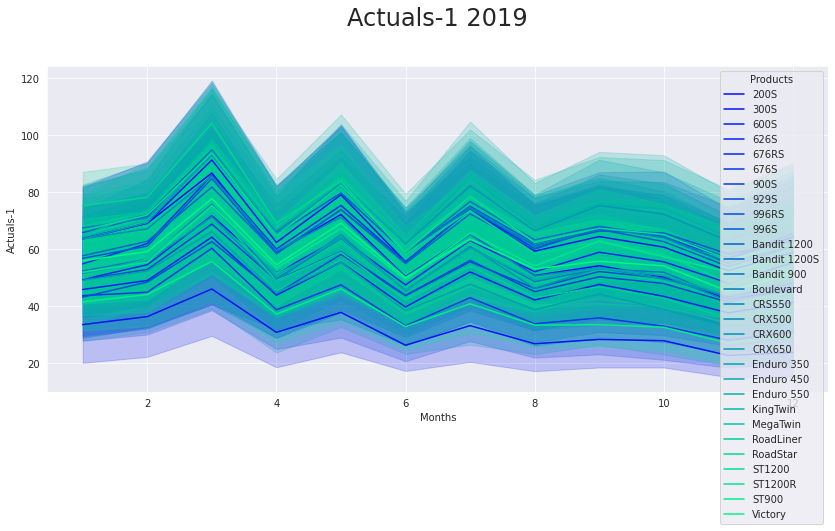

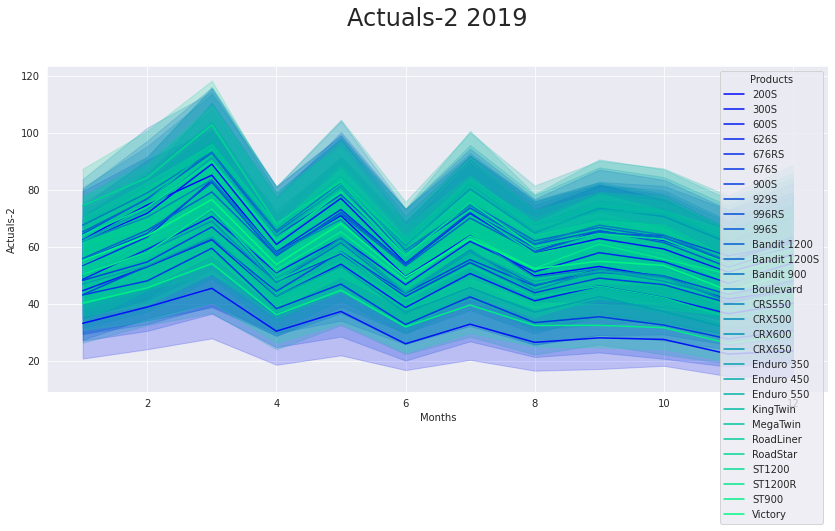

In [13]:
actual = ['Actuals', 'Actuals-1', 'Actuals-2']

for i in flattable['Year'].unique():
  df = flattable.loc[flattable['Year'] == i]
  df = pd.DataFrame(df, columns= ['Months','Year']) 
  df['Full Date'] = df['Months'].map(str) + '-' + df['Year'].map(str)
  
  for j in actual:
    plt.figure(figsize=(14,6))
    plt.title(j +" "+ str(i), fontsize=24, pad=40)
    sns.set_style('darkgrid')
    sns.lineplot(
        data = flattable,
        x = df['Months'],
        y = j,
        hue = 'Products',
        palette="winter"
    );

# New Sections

In [ ]:
flattable = flattable.sort_values(by=['Year', 'Months', 'Markets', 'Products'])

In [ ]:
flattable_full = pd.DataFrame()
flattable_full = flattable.copy()
flattable = flattable.loc[(flattable['Year'] == 2018) | (flattable['Year'] == 2017)].copy()
flattable.drop('Actuals-2', axis=1, inplace=True)

In [ ]:
sample_forecast = pd.DataFrame()
sample_forecast = flattable_full.loc[flattable_full['Year'] == 2019].copy()
sample_forecast['Actuals'] = 0
sample_forecast.drop('Actuals-2', axis=1, inplace=True)

In [ ]:
result = pd.DataFrame()
indicatorList = pd.DataFrame(columns=['Markets', 'Products',
      'MAPE-XG', 'RMSE-XG', 'TrainTime-XG', 'PredictTime-XG',
      'TotalProcessingTime-XG',
      'MAPE-RF', 'RMSE-RF', 'TrainTime-RF', 'PredictTime-RF',
      'TotalProcessingTime-RF'])
featureImpList = pd.DataFrame()
featurePD = pd.DataFrame()
mainFeaturePD = pd.DataFrame()
testDataPD = pd.DataFrame()

In [ ]:
indicatorCounter = 0
test_size = 0.25
sFolder = '/content/sample_data'
#sFolder = 'TrainModel'

In [ ]:
cluster = flattable['Markets'].unique().tolist()

## XGBoost

In [ ]:
# looping cluster based on lengths in columns
for i in range(len(cluster)):
    clust = cluster[i]
    currData = flattable.loc[flattable['Markets'] == clust].copy()
    prodList = np.asarray(currData['Products'].unique().tolist())

    # looped productList from Dataset
    for j in range(len(prodList)):
      prod = prodList[j]
      procData = currData.loc[currData['Products'] == prod].copy()
      labels = np.array(procData['Actuals'])
      finalData = procData.drop(['Actuals', 'Products', 'Markets', 'Version'], axis=1)

      totalData = int(np.round(len(finalData.index)))
      test_count = test_size * totalData
      train_count = int(totalData - test_count)

      # print(clust + "-" + prod.astype(str) + "-" + str(train_count))

      train_data = pd.DataFrame()
      test_data = pd.DataFrame()
      train_labels = []
      test_labels = []

      for k in range(train_count):
          train_data = train_data.append(finalData.iloc[[k]])
          train_labels.append(labels[k])
          

      for k in range(train_count, totalData):
          test_data = test_data.append(finalData.iloc[[k]])
          if labels[k] == 0:
              test_labels.append(0.01)
          else:
              test_labels.append(labels[k])

      columnList = list(finalData.columns)

      from sklearn.naive_bayes import GaussianNB
      # Naive Bayes
      timeStart = process_time()
      modelName = "Naive Bayes" + "-" + clust + "-" + prod.astype(str)
      model = GaussianNB()
      # train model
      timeStartTrain = process_time()
      model.fit(train_data, train_labels)
      timeEndTrain = process_time()
      # end
      # predict
      timeStartPredict = process_time()
      predData = model.predict(test_data)
      timeEndPredict = process_time()
      mape = mean_absolute_percentage_error(test_labels, predData)
      rmse = sqrt(mean_squared_error(test_labels, predData))
      # mapejudul = "MAPE = " + str(mape)
      # subjudul = "Attrition GradientBoosting: Top 5 Features - %s" %(mapejudul)
      # plot_feature_importance(feature_list=train_data.columns.tolist(),
      #       feature_importances=model.feature_importances_,
      #       title=subjudul)
      timeEnd = process_time()
      proccesingTime = timeEnd - timeStart

      indicatorList.at[indicatorCounter, 'Markets'] = clust
      indicatorList.at[indicatorCounter, 'Products'] = prod
      indicatorList.at[indicatorCounter, 'MAPE-XG'] = mape
      indicatorList.at[indicatorCounter, 'RMSE-XG'] = rmse
      indicatorList.at[indicatorCounter, 'TrainTime-XG'] = timeEndTrain - timeStartTrain
      indicatorList.at[indicatorCounter, 'PredictTime-XG'] = timeEndPredict - timeStartPredict
      indicatorList.at[indicatorCounter, 'TotalProcessingTime-XG'] = proccesingTime
      
      sFolder = '/content/sample_data'
      filename = sFolder + '/' + modelName + '.pkl'
      pickle.dump(model, open(filename, 'wb'))

      print('Navive Bayes Feature Importance: ')
      importances = list(model.feature_importances_)
      feature_importances = [(feature, round(importance, 2)) for feature, importance in
         zip(columnList, importances)]
      # feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
      [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
      # End XGBoost
      featurePD = pd.DataFrame(feature_importances)
      featurePD = featurePD.transpose()
      new_header = featurePD.iloc[0]  # grab the first row for the header
      featurePD = featurePD[1:]  # take the data less the header row
      featurePD.columns = new_header

      mainFeaturePD = pd.DataFrame(columns=['Markets', 'Products','Method'])
      mainFeaturePD.at[1, 'Markets'] = clust
      mainFeaturePD.at[1, 'Products'] = prod
      mainFeaturePD.at[1, 'Method'] = 'XGBoost'
      mainFeaturePD = mainFeaturePD.merge(featurePD, left_index=True, right_index=True)
      featureImpList = featureImpList.append(mainFeaturePD)

      predDataTable = test_data.reset_index().merge(
          pd.DataFrame(predData, columns=['Prediction']), 
          left_index=True, 
          right_index=True
          )
      
      predDataTable.insert(0, 'Method', 'XGBoost')
      predDataTable.insert(1, 'Markets', clust)
      predDataTable.insert(2, 'Product', prod)

      testDataPD = testDataPD.append(predDataTable)

result = pd.DataFrame()

ValueError: ignored